# Importing Dataset
Importing in the dataset from google drive rather than immediate ones

**NOTE** : This is really bad colab still works on python 3.8 so no struct pattern matching or even typing shortcuts. Hard despair. Might need to develop flags to actually work with on the data

In [ ]:
# Datasets
import google.colab.drive
import numpy
google.colab.drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
train_x = numpy.load("/content/drive/My Drive/Datasets/Images/train_x.npy", allow_pickle=True)
train_y = numpy.load("/content/drive/My Drive/Datasets/Images/train_y.npy", allow_pickle=True)
test_x  = numpy.load("/content/drive/My Drive/Datasets/Images/test_x.npy" , allow_pickle=True)
test_y  = numpy.load("/content/drive/My Drive/Datasets/Images/test_y.npy" , allow_pickle=True)
valid_x = numpy.load("/content/drive/My Drive/Datasets/Images/valid_x.npy", allow_pickle=True)
valid_y = numpy.load("/content/drive/My Drive/Datasets/Images/valid_y.npy", allow_pickle=True)

print(f"Training   setx shape : {train_x.shape}")
print(f"Training   sety shape : {train_y.shape}")
print(f"Testing    setx shape : {test_x.shape}")
print(f"Testing    sety shape : {test_y.shape}")
print(f"Validation setx shape : {valid_x.shape}")
print(f"Validation sety shape : {valid_y.shape}")

Training   setx shape : (45000, 3, 64, 64)
Training   sety shape : (45000,)
Testing    setx shape : (10000, 3, 64, 64)
Testing    sety shape : (10000,)
Validation setx shape : (15000, 3, 64, 64)
Validation sety shape : (15000,)


# Importing libraries and stuff

In [ ]:
import keras
import keras.layers
import keras.models
import keras.backend
import keras.applications
import tensorflow
import matplotlib
import random
import typing
import itertools
import os
import datetime

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import tensorflow as tf
import datetime, os
import multiprocessing
pool = multiprocessing.Pool()
pool._processes

2

# Showing a Random Image
We try to produce a random image out of the whole dataset and check how the evaluation is usually done

This image has a y value of : 0
[0.5823812  0.65565443 0.75694436]


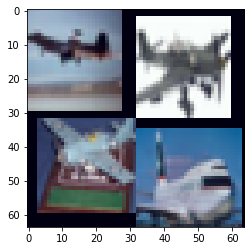

In [ ]:

# Reshaping all the dataset
# Imshow prefers printing out in the form x,y,channel
# The dataset is normalized back to 0 and 1 to print
rescale_0_1 = lambda x : (x - x.min())/(x.max() - x.min())
show_random_image = lambda : train_x[random.randint(0,train_x.shape[0]-1)]

def show_random_train_image_with_idx(return_idx = False) -> typing.Union[int, None] :
  index : int = random.randint(0, train_x.shape[0] - 1)
  matplotlib.pyplot.imshow(
      rescale_0_1(
          numpy.moveaxis(train_x[index], 0, -1)
      )
  )
  if (return_idx == True): return index
  else : print(index)
  
# matplotlib.pyplot.imshow(rescale_0_1(numpy.moveaxis(show_random_image(), 0, -1)))
index : int = show_random_train_image_with_idx(return_idx=True)
print(f"This image has a y value of : {train_y[index]}")
black_pixels : int = 0
print(rescale_0_1(numpy.moveaxis(train_x[index], 0 , -1))[0,0,:])
# for i,j in itertools.product(range(64), range(64)):

# Histogramic Analysis
We show that thrugh histogrmixc analysis there is a section that we can favour to remove to eliminate most of teh balck pixels in our data and we can use this modified datset for training purposes and even for the test purpses we can section out out test data and fit into our model.

100%|██████████| 45000/45000 [17:15<00:00, 43.47it/s]


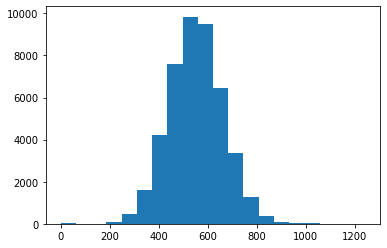

In [ ]:
# Trying to see how many of them actually have a black pixel
# Not necessarily the actual value but should be around true value
import itertools
import tqdm

black_pixels_counter = []
for i in tqdm.trange(len(train_x)):
  x = train_x[i]
  rescaled = rescale_0_1(numpy.moveaxis(x, 0, -1))
  count = 0
  for i,j in itertools.product(range(rescaled.shape[0]), range(rescaled.shape[1])):
    if (rescaled[i,j,:] <= numpy.array([0.0001,0.005,0.08])).all():
      count += 1
  black_pixels_counter.append(count)

matplotlib.pyplot.hist(black_pixels_counter, bins = 20)
matplotlib.pyplot.show()


100%|██████████| 45000/45000 [06:09<00:00, 121.72it/s]


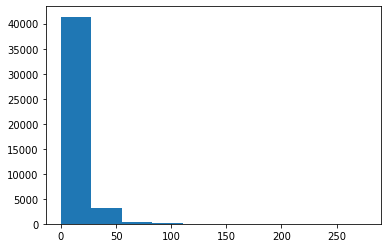

In [ ]:

# We shall also show a comapritive graph of how many of these lie in the areas that definitely are the images and check validity
# The ranges for actually finding the black pixelss are ((10,20), (40,50)) and all combinations

import itertools
section = ((5,25), (35,55))


black_pixel_why_there_counter = []

for i in tqdm.trange(len(train_x)):
  x = train_x[i]
  rescaled = rescale_0_1(numpy.moveaxis(x, 0, -1))
  count = 0
  for x,y in itertools.product(section, section):
    for i,j in itertools.product(range(x[0], x[1]), range(y[0], y[1])):
      if (rescaled[i,j,:] <= numpy.array([0.0001,0.005,0.08])).all():
        count += 1
  black_pixel_why_there_counter.append(count)

matplotlib.pyplot.hist(black_pixel_why_there_counter)
matplotlib.pyplot.show()
    
  

In [ ]:
import statistics

print(statistics.quantiles(black_pixels_counter, n = 6))
print(statistics.quantiles(black_pixel_why_there_counter, n = 6))

print(black_pixel_why_there_counter > numpy.zeros(black_pixel_why_there_counter.__len__()))

print(numpy.count_nonzero(black_pixel_why_there_counter > numpy.zeros(black_pixel_why_there_counter.__len__())))

print(f"{len(black_pixels_counter)} - {len(black_pixel_why_there_counter)}")

# So there is only one pixel in that region which have complete black pixel 

[439.0, 500.0, 556.0, 610.0, 670.0]
[0.0, 0.0, 0.0, 0.0, 1.0]
[False False False ... False False False]
8764
45000 - 45000


100%|██████████| 45000/45000 [07:53<00:00, 95.07it/s]


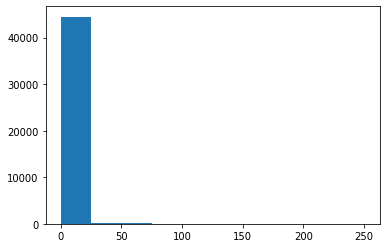

In [ ]:

import itertools
section = ((5,27), (37,59))


black_pixel_why_there_counter = []

for i in tqdm.trange(len(train_x)):
  x = train_x[i]
  rescaled = rescale_0_1(numpy.moveaxis(x, 0, -1))
  count = 0
  for x,y in itertools.product(section, section):
    for i,j in itertools.product(range(x[0], x[1]), range(y[0], y[1])):
      if (rescaled[i,j,:] <= numpy.array([0.0001,0.005,0.08])).all():
        count += 1
  black_pixel_why_there_counter.append(count)

matplotlib.pyplot.hist(black_pixel_why_there_counter)
matplotlib.pyplot.show()
   

## Notes on shit above

What we have done is prove a claim that most of the absurdities occur around the region window shaped somewhat like this : 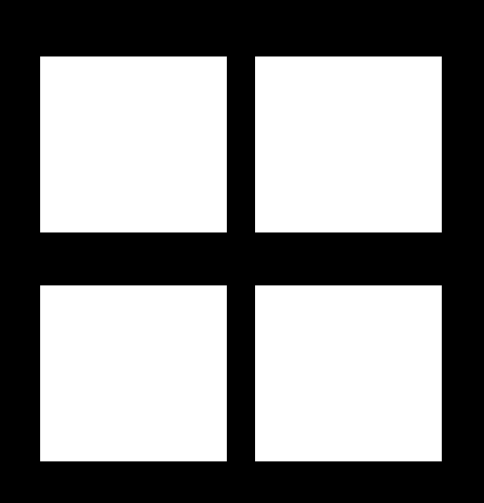

Now to make sense of this :

Initially we have the count of almost black pixels (RGB $\in [0,1)$ ) using this logic we see that most of the dataset has a median of around 2081. So by logic if these black pixels were evenly distibuted in the daatset then it shoudl come around 10% which it actually does?

# To mask or not to mask

In [ ]:
# Unmasked array still required rescaling
num_classes = 4

train_x_scaled = [rescale_0_1(x) for x in train_x]
valid_x_scaled = [rescale_0_1(x) for x in valid_x]
test_x_scaled  = [rescale_0_1(x) for x in  test_x]

## Masked case

In [ ]:
# We will dp the default working with what was presented in the class
batch_size = 128
num_classes = 4
epochs = 10

sections = list(range(5,27)) + list(range(27,59))

# Slicing is weird in numpy
x_train = numpy.moveaxis(train_x_scaled, [0,1,2,3], [0,3,1,2])[:, : , sections, :][:, sections, : , :]
x_valid = numpy.moveaxis(valid_x_scaled, [0,1,2,3], [0,3,1,2])[:, : , sections, :][:, sections, : , :]
x_test  = numpy.moveaxis(test_x_scaled,  [0,1,2,3], [0,3,1,2])[:, : , sections, :][:, sections, : , :]
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(train_y, num_classes)
y_valid = keras.utils.to_categorical(valid_y, num_classes)
y_test = keras.utils.to_categorical(test_y, num_classes)

del(train_x_scaled)
del(valid_x_scaled)
del(test_x_scaled)
del(train_y)
del(valid_x)
del(test_y)

(45000, 54, 54, 3)
(15000, 54, 54, 3)
(10000, 54, 54, 3)
(45000, 4)
(15000, 4)
(10000, 4)


## Unmasked case

In [ ]:
# Slicing is weird in numpy
x_train = numpy.moveaxis(train_x, [0,1,2,3], [0,3,1,2])
x_valid = numpy.moveaxis(valid_x, [0,1,2,3], [0,3,1,2])
x_test = numpy.moveaxis(test_x, [0,1,2,3], [0,3,1,2])

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(train_y, num_classes)
y_valid = keras.utils.to_categorical(valid_y, num_classes)
y_test = keras.utils.to_categorical(test_y, num_classes)

del(train_x_scaled)
del(valid_x_scaled)
del(test_x_scaled)
del(train_y)
del(valid_x)
del(test_y)

# Some tf callbacks

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/My Drive/Models/weights-{epoch:02d}-{val_accuracy:.2f}.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


# Select Model

## Class (Elly) Model

In [ ]:
class EllyModel(keras.Model):

  def __init__(self, num_of_classes : int):
    super().__init__()
    self.conv2d_1       = keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu')
    self.max_pool_2d_1  = keras.layers.MaxPooling2D(pool_size = (2,2))
    self.conv_2d_2      = keras.layers.Conv2D(64, (3,3), activation = 'relu')
    self.max_pool_2d_2  = keras.layers.MaxPooling2D(pool_size = (2,2))
    self.dropout_1      = keras.layers.Dropout(0.25)
    self.flatten_1      = keras.layers.Flatten()
    self.dense_1        = keras.layers.Dense(128, activation = 'relu')
    self.dropout_2      = keras.layers.Dropout(0.5)
    self.dense_2        = keras.layers.Dense(num_of_classes, activation='softmax')

  def call(self, inputs, training=False):
    x = self.conv2d_1(inputs)
    x = self.max_pool_2d_1(x)
    x = self.conv_2d_2(x)
    x = self.max_pool_2d_2(x)
    if training:
      x = self.dropout_1(x, training=training)
    x = self.flatten_1(x)
    x = self.dense_1(x)
    if training: x = self.dropout_2(x, training = training)
    return self.dense_2(x)



In [ ]:
model = EllyModel(4)
model.build([None] + list(x_train.shape[1:]))

## ResNet-50

In [ ]:
# Resnet50
base_model = keras.applications.ResNet50(include_top = False, input_shape = x_train.shape[1:])

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
predictions = keras.layers.Dense(4, activation='softmax')(x)

# this is the model we will train
model = keras.Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#   layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
# model.summary()

94765736/94765736 [==============================] - 1s 0us/step


## DenseNet169

In [ ]:
# DenseNet169
base_model = keras.applications.DenseNet169(
    include_top = False, 
    input_shape = x_train.shape[1:])

# this is the model we will train
# base_model.summary()
x = base_model.output
x = keras.layers.Flatten()(x)
predictions = keras.layers.Dense(10, activation='softmax')(x)
predictions = keras.layers.Dense(1000, activation = 'softmax')(x)
predictions = keras.layers.Dense(1000, activation = 'softmax')(x)
predictions = keras.layers.Dense(1000, activation = 'relu')(x)
predictions = keras.layers.Dense(4)(x)

# this is the model we will train
model = keras.Model(inputs=base_model.input, outputs=predictions)
del(base_model)
del(x)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#   layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss=keras.losses.MSE, 
              optimizer = 'adamax', metrics=['accuracy'])
# model.summary()

## DenseNet201

In [ ]:
# DenseNet201
base_model = keras.applications.DenseNet201(
    include_top = False, 
    input_shape = x_train.shape[1:])

# this is the model we will train
# base_model.summary()
x = base_model.output
x = keras.layers.Flatten()(x)
predictions = keras.layers.Dense(4, activation='softmax')(x)

# this is the model we will train
model = keras.Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#   layer.trainable = False
del(base_model)
del(x)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer = 'adamax', metrics=['accuracy'])
# model.summary()

74836368/74836368 [==============================] - 0s 0us/step


# Training and First Eval

## Fitting the model

In [ ]:
history = model.fit(
    x= x_train,
    y= y_train,
    batch_size=None,
    epochs= 100,
    verbose="auto",
    callbacks=[tensorboard_callback, callback, model_checkpoint_callback],
    validation_split=0.0,
    validation_data=(x_valid, y_valid),
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=4,
    use_multiprocessing=True,
)

Epoch 1/100
1407/1407 [==============================] - 193s 115ms/step - loss: 1.4969 - accuracy: 0.3422 - val_loss: 1.2256 - val_accuracy: 0.4081
Epoch 2/100
1407/1407 [==============================] - 154s 109ms/step - loss: 1.3119 - accuracy: 0.4187 - val_loss: 2.0120 - val_accuracy: 0.4589
Epoch 3/100
1407/1407 [==============================] - 155s 110ms/step - loss: 1.2088 - accuracy: 0.4590 - val_loss: 5.3583 - val_accuracy: 0.4395
Epoch 4/100
1407/1407 [==============================] - 167s 119ms/step - loss: 1.1257 - accuracy: 0.5003 - val_loss: 1.2134 - val_accuracy: 0.5239
Epoch 5/100
1407/1407 [==============================] - 171s 122ms/step - loss: 1.0214 - accuracy: 0.5420 - val_loss: 4.4749 - val_accuracy: 0.5565
Epoch 6/100
1407/1407 [==============================] - 163s 116ms/step - loss: 0.9350 - accuracy: 0.5848 - val_loss: 0.9853 - val_accuracy: 0.5830
Epoch 7/100
1407/1407 [==============================] - 153s 109ms/step - loss: 0.8359 - accuracy: 0.6279

## Evaluation

In [ ]:
score = model.evaluate(
    x=x_test,
    y=y_test,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=4,
    use_multiprocessing=True,
    return_dict=False,
    # **kwargs
)
print(f"Final score is :  (Loss -> {score[0]}) , (Accuracy -> {score[1]}")

313/313 [==============================] - 11s 34ms/step - loss: 1.5822 - accuracy: 0.6191
Final score is :  (Loss -> 1.5822479724884033) , (Accuracy -> 0.6190999746322632


# Save Model

In [ ]:
import datetime
filename : str = datetime.datetime.now().__str__()
model.save(f"/content/drive/My Drive/Models/densenet169_{filename}_unmasked.tf")
model.save(f"/content/drive/My Drive/Models/densenet169_{filename}_unmasked.h5")

In [ ]:
# Save it somewhere
!cp -r /content/logs "/content/drive/My Drive/Logs/densenet169_unmasked"

# Tensorflow

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/logs

# Memory clearance

In [ ]:
# clearing out unnecessary variables modules
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
    
unnecessary_variables = [
    'x_train_reshaped',
    'x_valid_reshaped',
    'x_test_reshaped',
    #'y_train',
    #'y_valid',
    #'y_test',
    'history',
    # 'model',
    'base_model',
    'x',
    'sections',
    'pool']

for var in unnecessary_variables:
  try:
    exec(f"del({var})")
  except Exception as e: 
    print(e)

gc.collect()

name 'x_train_reshaped' is not defined
name 'x_valid_reshaped' is not defined
name 'x_test_reshaped' is not defined
name 'history' is not defined
name 'base_model' is not defined
name 'x' is not defined
name 'sections' is not defined


1769

# Final test

In [ ]:
print('Done')